In [36]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import os
import itertools
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.pyplot as plt

In [2]:
# model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3-8B")
# in_embed_name = "model.embed_tokens.weight"
# out_embed_name = "lm_head.weight"
#
# all_params = dict(model.named_parameters())
# input_embeds = all_params[in_embed_name].data
# output_embeds = all_params[out_embed_name].data
#
#
# torch.save(input_embeds, "data/input_embeds.pt")
# torch.save(output_embeds, "data/output_embeds.pt")

In [3]:
tk = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [50]:
input_embeds = torch.load("data/input_embeds.pt")
output_embeds = torch.load("data/output_embeds.pt")

In [5]:
input_embeds.shape

torch.Size([128256, 4096])

In [6]:
king, queen, male, female = tk.convert_tokens_to_ids(
    ["Ġking", "Ġqueen", "Ġmale", "Ġfemale"]
)

In [7]:
king, queen, male, female

(11734, 29006, 8762, 8954)

In [8]:
k, q, m, f = [input_embeds[x] for x in (king, queen, male, female)]

In [9]:
k.shape

torch.Size([4096])

In [10]:
torch.sum((k - q).abs()), torch.sum((m - f).abs()), torch.sum((k - f).abs()), torch.sum(
    (k - m).abs()
)

(tensor(31.1095), tensor(27.2039), tensor(37.4152), tensor(35.8423))

In [11]:
torch.sum(((k + f - m) - q).abs())

tensor(41.0893)

In [12]:
def king_queen_test(embeds, tk):
    def norm1(x):
        return torch.sum(torch.abs(x)).item()

    king, queen, male, female = tk.convert_tokens_to_ids(
        ["Ġking", "Ġqueen", "Ġmale", "Ġfemale"]
    )
    k, q, m, f = [embeds[x] for x in (king, queen, male, female)]
    print("king - queen", norm1(k - q))
    print("male - female", norm1(m - f))
    print("king - male", norm1(k - m))
    print("king - female", norm1(k - f))
    print("king + female - male - queen", norm1(k + f - m - q))

In [13]:
king_queen_test(input_embeds, tk)

king - queen 31.109458923339844
male - female 27.203916549682617
king - male 35.84231185913086
king - female 37.41519546508789
king + female - male - queen 41.089317321777344


In [15]:
# king_queen_test(output_embeds, tk)

In [41]:
appearance_adjectives = (
    "attractive",
    "bald",
    "beautiful",
    "chubby",
    "clean",
    "dazzling",
    "drab",
    "elegant",
    "fancy",
    "fit",
    "flabby",
    "glamorous",
    "gorgeous",
    "handsome",
    "long",
    "magnificent",
    "muscular",
    "plain",
    "plump",
    "quaint",
    "scruffy",
    "shapely",
    "short",
    "skinny",
    "stocky",
    "ugly",
    "unkempt",
    "unsightly",
)

In [42]:
color_adjectives = (
    "ashy",
    "black",
    "blue",
    "gray",
    "green",
    "icy",
    "lemon",
    "mango",
    "orange",
    "purple",
    "red",
    "salmon",
    "white",
    "yellow",
)

In [43]:
places = (
    "School",
    "Hospital",
    "Restaurant",
    "Airport",
    "Office",
    "Beach",
    "Forest",
    "Church",
    "Library",
    "Theater",
)

In [44]:
verbs = (
    "Be",
    "Have",
    "Do",
    "Make",
    "Go",
    "Take",
    "Come",
    "See",
    "Get",
    "Give",
    "Know",
    "Think",
    "Find",
    "Say",
    "Tell",
    "Use",
    "Look",
    "Work",
    "Call",
    "Try",
    "Ask",
    "Leave",
    "Feel",
    "Put",
    "Mean",
    "Keep",
    "Let",
    "Begin",
    "Seem",
    "Help",
    "Talk",
    "Turn",
    "Start",
    "Might",
    "Show",
    "Hear",
    "Play",
    "Run",
    "Move",
    "Like",
    "Live",
    "Believe",
    "Hold",
    "Bring",
)

In [45]:
def interal_similarity(embeds, tk, words):
    ids = [x for x in tk.convert_tokens_to_ids(words) if x is not None]
    print(f"{len(words)-len(ids)} words more than one token")
    vecs = torch.stack([embeds[x] for x in ids])
    norm1 = torch.sum(
        torch.abs(vecs.repeat(len(vecs), 1) - vecs.repeat_interleave(len(vecs), dim=0))
    ) / (len(vecs) * (len(vecs) - 1))
    norm2 = torch.sum(
        (vecs.repeat(len(vecs), 1) - vecs.repeat_interleave(len(vecs), dim=0)).pow(2)
    ) / (len(vecs) * (len(vecs) - 1))

    return norm1.item(), norm2.item()

In [46]:
appearance_adjectives, color_adjectives, places, verbs = [
    ["Ġ" + x.lower() for x in y]
    for y in (appearance_adjectives, color_adjectives, places, verbs)
]

In [21]:
places

['Ġschool',
 'Ġhospital',
 'Ġrestaurant',
 'Ġairport',
 'Ġoffice',
 'Ġbeach',
 'Ġforest',
 'Ġchurch',
 'Ġlibrary',
 'Ġtheater']

In [22]:
interal_similarity(output_embeds, tk, appearance_adjectives)

NameError: name 'output_embeds' is not defined

In [23]:
school = tk.convert_tokens_to_ids("Ġschool")
airport = tk.convert_tokens_to_ids("Ġairport")
blue = tk.convert_tokens_to_ids("Ġblue")
black = tk.convert_tokens_to_ids("Ġblack")

In [24]:
blue, black, school, airport = [input_embeds[x] for x in (blue, black, school, airport)]

In [25]:
blue.abs().sum(), black.abs().sum(), school.abs().sum(), airport.abs().sum()

(tensor(25.5631), tensor(25.3781), tensor(24.3225), tensor(30.9524))

In [26]:
(blue - black).abs().sum(), (school - airport).abs().sum(), (
    blue - school
).abs().sum(), (blue - airport).abs().sum()

(tensor(29.4910), tensor(35.6619), tensor(32.4840), tensor(38.8277))

In [51]:
use_embeds = output_embeds

In [52]:
pca = IncrementalPCA(n_components=2, batch_size=100)
pca.fit(use_embeds[:10000])

IncrementalPCA(batch_size=100, n_components=2)

In [53]:
ids = [x for x in tk.convert_tokens_to_ids(places) if x is not None]
embeds = use_embeds[ids]

In [54]:
pca_embeds = pca.transform(embeds)

In [55]:
pca_embeds

array([[ 0.18265882,  0.09365605],
       [ 0.06621856,  0.07392839],
       [ 0.04430844,  0.05028866],
       [ 0.00748696,  0.04295382],
       [ 0.1507649 ,  0.07784452],
       [ 0.08033056,  0.05986979],
       [ 0.07855648,  0.08869194],
       [ 0.07005025,  0.06651732],
       [ 0.08995273,  0.06242042],
       [-0.0046071 ,  0.03701215]])

In [56]:
def plot_pca(pca: PCA, words: list[str], label=None, color=None):
    ids = [x for x in tk.convert_tokens_to_ids(words) if x is not None]
    embeds = use_embeds[ids]
    pca_embeds = pca.transform(embeds)
    plt.scatter(pca_embeds[:, 0], pca_embeds[:, 1], label=label, color=color)

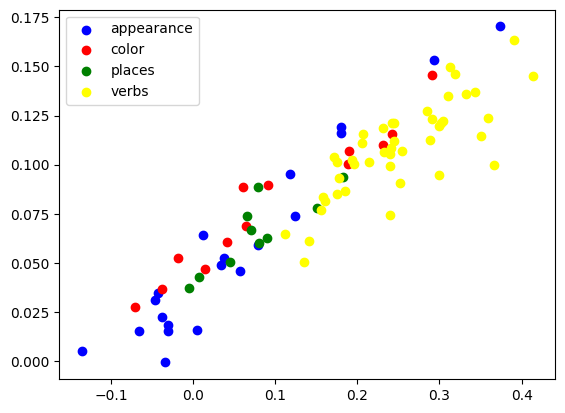

In [58]:
plot_pca(pca, appearance_adjectives, label="appearance", color="blue")
plot_pca(pca, color_adjectives, label="color", color="red")
plot_pca(pca, places, label="places", color="green")
plot_pca(pca, verbs, label="verbs", color="yellow")
plt.legend()
plt.savefig("plots/pca_output_embeds.png")